# Forecasting the outflow of customers in the hotel chain "Like a guest"

The customer of this study is the "Like a guest" hotel chain.

To attract customers, this hotel chain has added the ability to book a room without prepayment on its website. However, if the client canceled the booking, then the company suffered losses.

It is necessary to develop a system that predicts the rejection of the reservation. If the model shows that the booking will be cancelled, then the client is asked to make a deposit. The deposit is 80% of the cost of the room for one day and the cost of one-time cleaning. The money will be debited from the client's account if he still cancels the reservation.

The hotel has several types of rooms. Depending on the type of room, the cost is per night. There are also cleaning costs. If the client rented a room for a long time, then they are cleaned every two days.

**Main business metric** - profit.

**The purpose of the study** is to obtain a model, the result of which is maximizing profit

**Basic data**
- category A: per night - 1,000, one-time service - 400;
- category B: per night - 800, one-time service - 350;
- category C: per night - 600, one-time service - 350;
- category D: per night - 550, one-time service - 150;
- category E: per night - 500, one-time service - 150;
- category F: per night - 450, one-time service - 150;
- category G: per night - 350, one-time service - 150.

The hotel's pricing policy uses seasonal factors: in spring and autumn, prices increase by 20%, in summer - by 40%.

The budget for the development of the forecasting system is 400,000. The implementation of the model should pay off in a year. Development costs should be less than the revenue that the system will bring to the company.

### Step 1. Data review

In [1]:
!pip install -U scikit-learn --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import datetime as dt


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from scipy import stats as st
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from numpy import math                              
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn import tree

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
train = pd.read_csv(r'C:\Users\Vadim\Documents\Datasets\hotel_train.csv')
test = pd.read_csv(r'C:\Users\Vadim\Documents\Datasets\hotel_test.csv')

In [4]:
list_ = [train, test]
for i in list_:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

In [5]:
list_ = [train, test]
for i in list_:
    display(i.head(5))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [6]:
list_ = [train, test]
for i in list_:
    display(i.describe())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [7]:
list_ = [train, test]
for i in list_:
    display(i.duplicated().value_counts())

False    65229
dtype: int64

False    32412
dtype: int64

C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-p

C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Vadim\anaconda3\lib\site-p

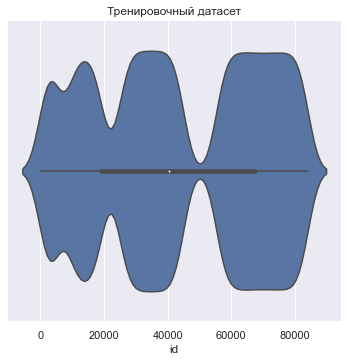

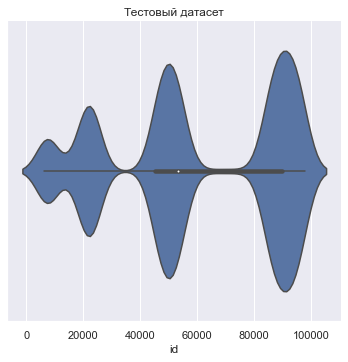

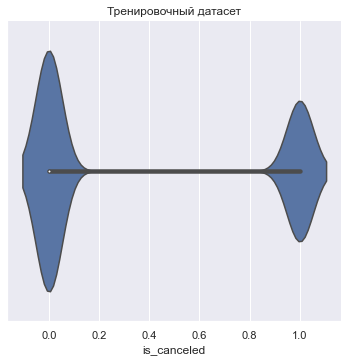

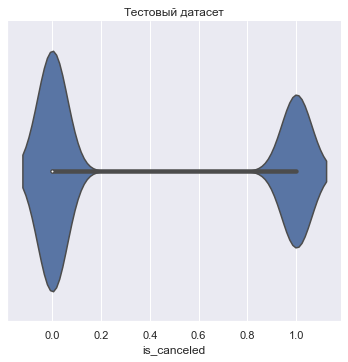

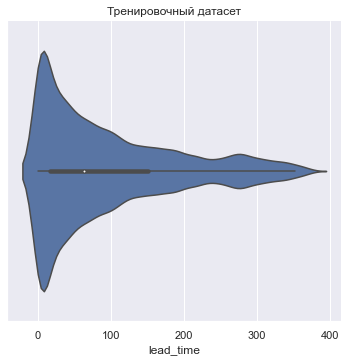

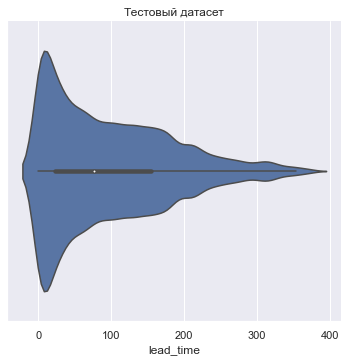

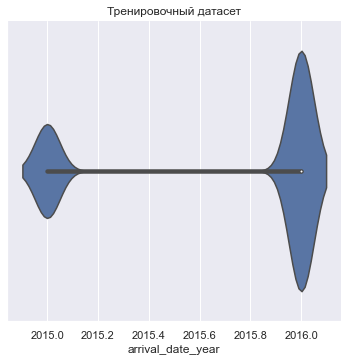

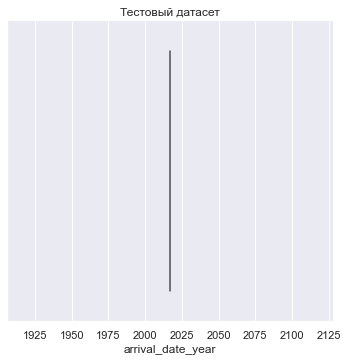

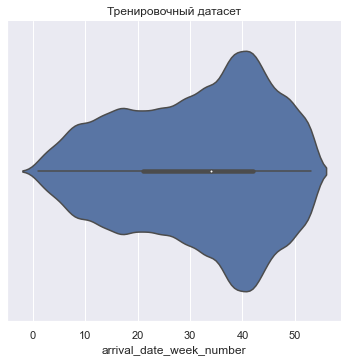

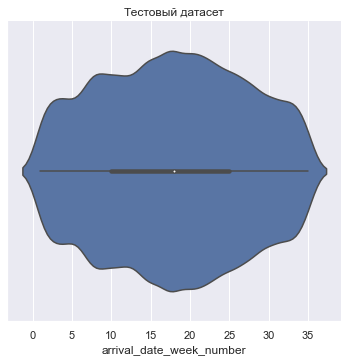

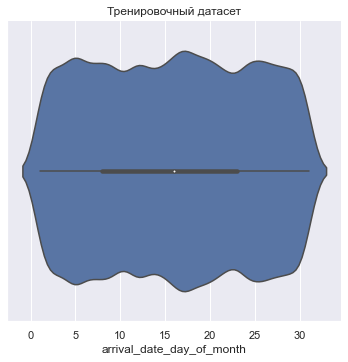

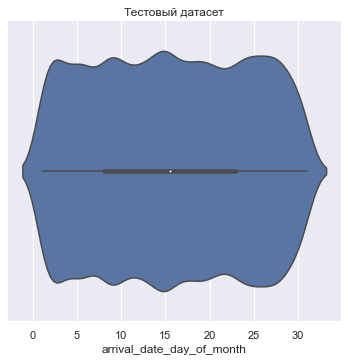

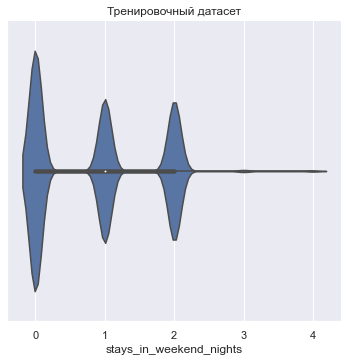

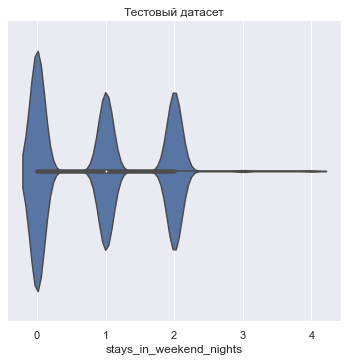

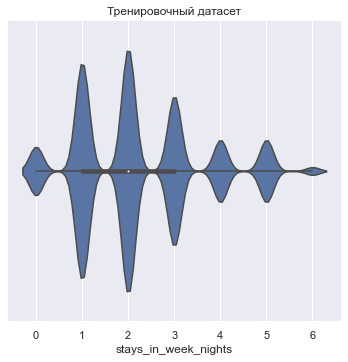

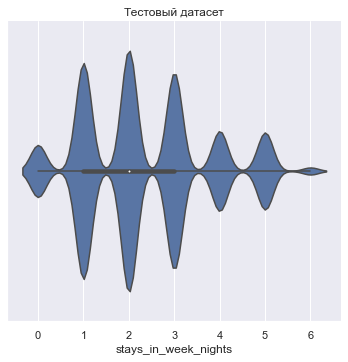

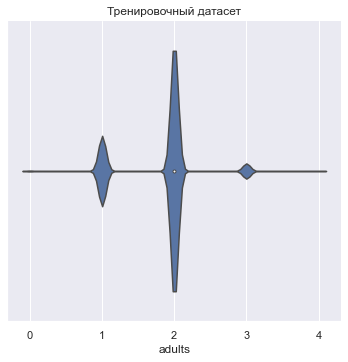

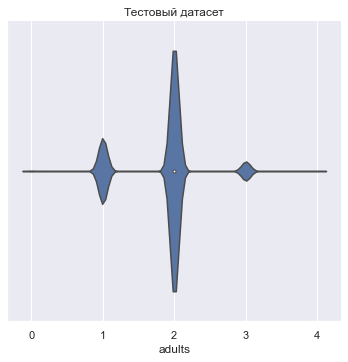

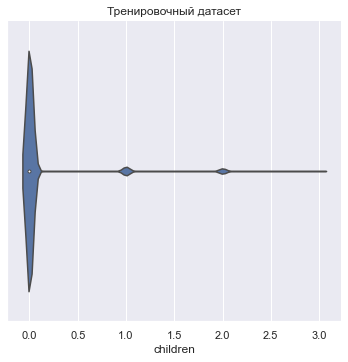

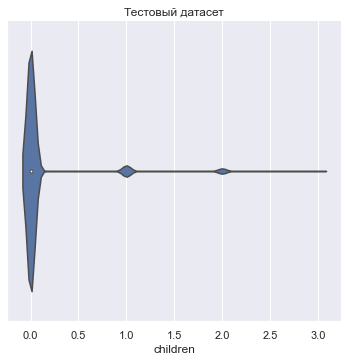

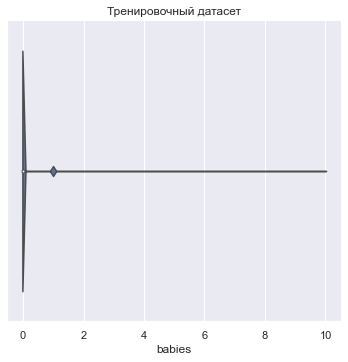

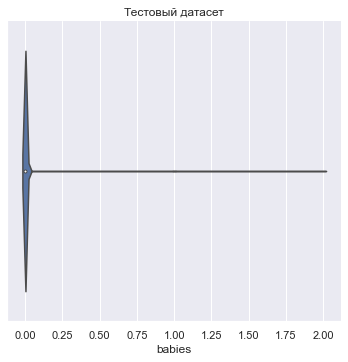

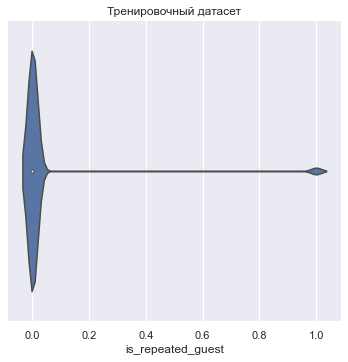

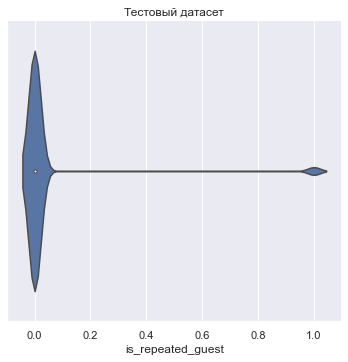

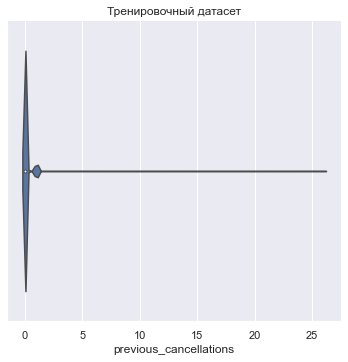

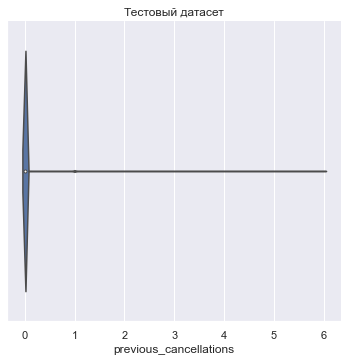

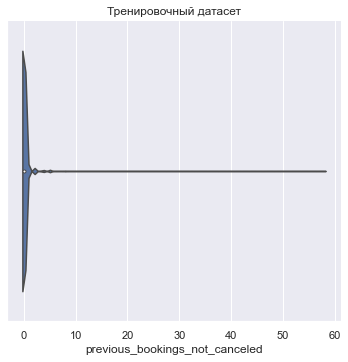

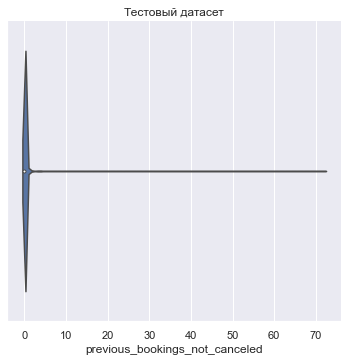

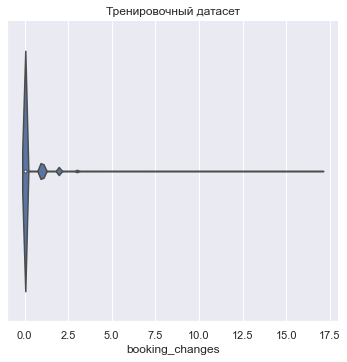

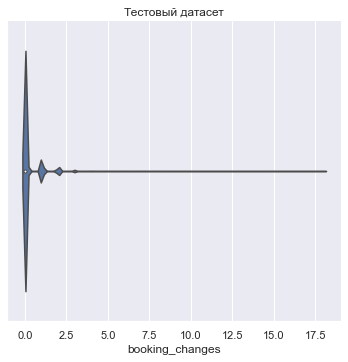

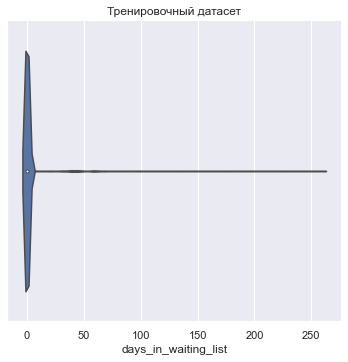

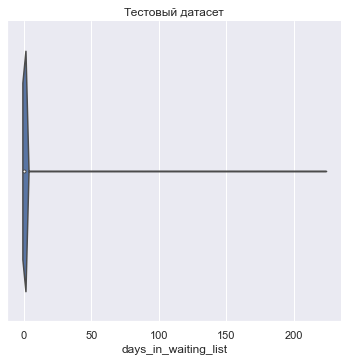

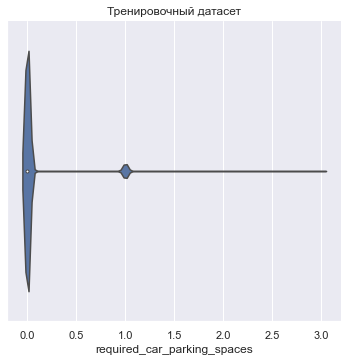

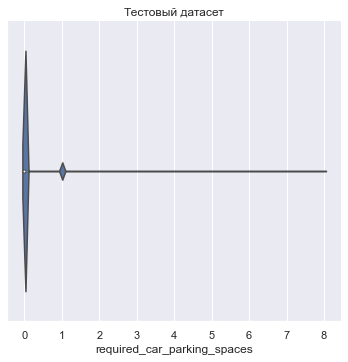

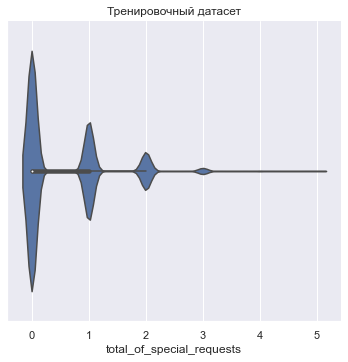

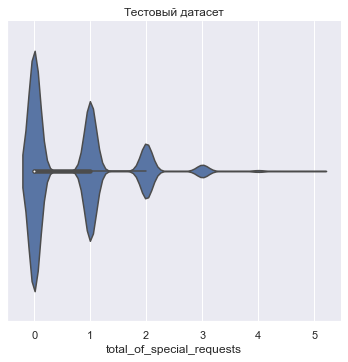

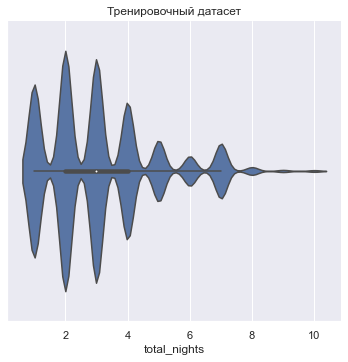

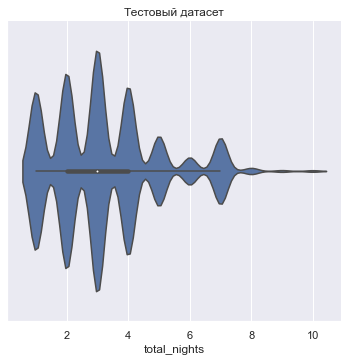

In [8]:
list_ = [train, test]
for column in train.columns:
    for tab in list_:
        if tab[column].dtype == 'int64' or tab[column].dtype == 'float64':
            display(_=sns.catplot(x=column, kind="violin", data=tab, orient='v'))
            if tab is train:
                plt.title('Тренировочный датасет')
            else:
                plt.title('Тестовый датасет')

**Conclusion:** 

At the initial analysis of the data, we can say that both dataframes do not contain the null data type, there are no obvious duplicates. This makes further processing easier.

The training set has 65k rows, the test set has 32k and 25 columns in each set. The data has a categorical type (object), a numeric discrete type (int64), and a numeric continuous type (float64).

For the model to work correctly, it will be necessary:
- encode categorical data type
- scale numeric types
- bring balancing unbalanced classes

### Step 2. Pre-processing and exploratory data analysis

#### Exploratory data analysis

##### Data review on the correlation matrix

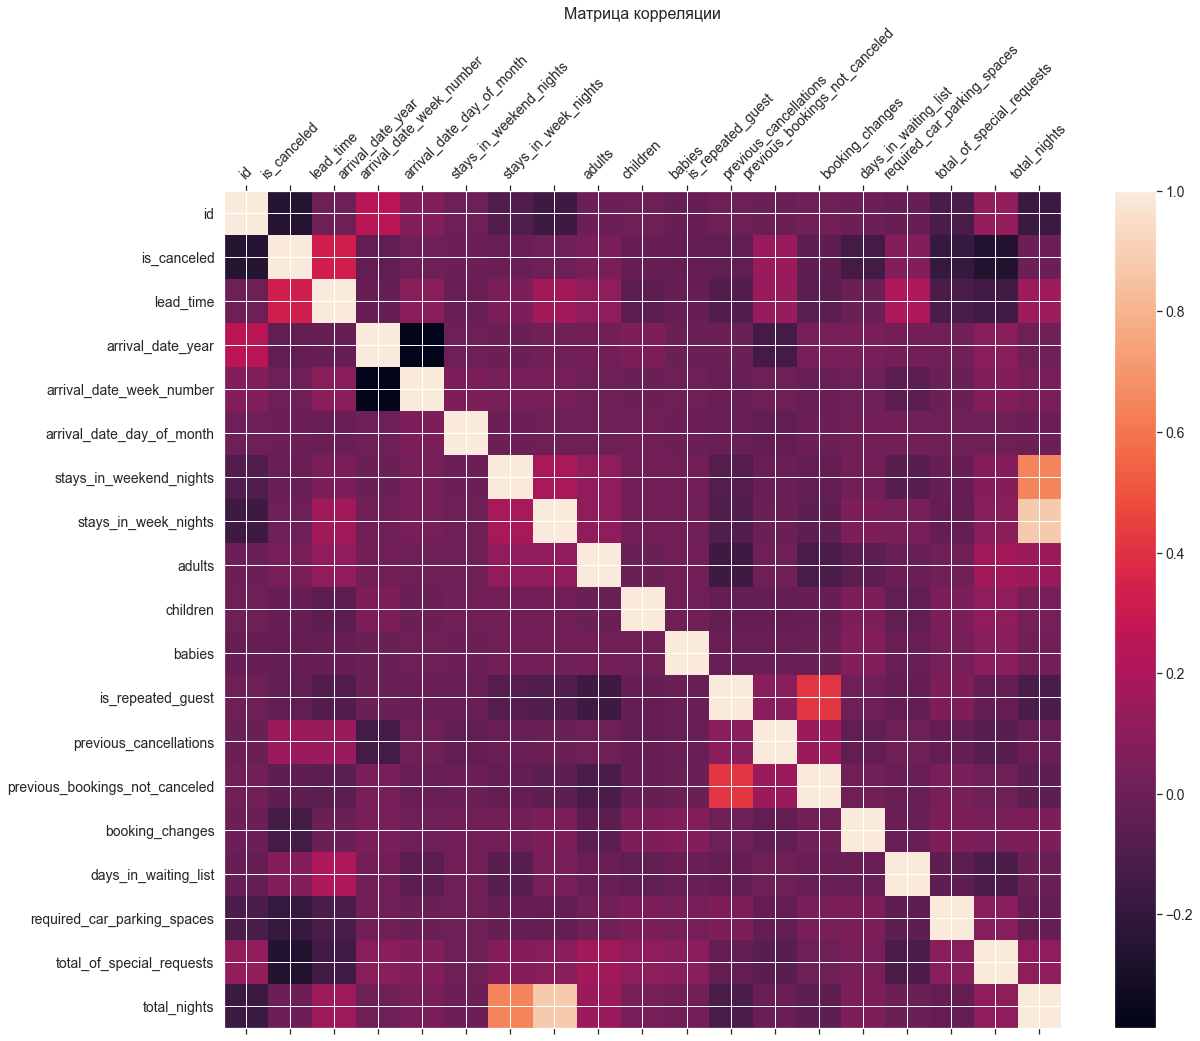

In [9]:
f = plt.figure(figsize=(19, 15))
plt.matshow(train.corr(), fignum=f.number)
plt.xticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Матрица корреляции', fontsize=16);

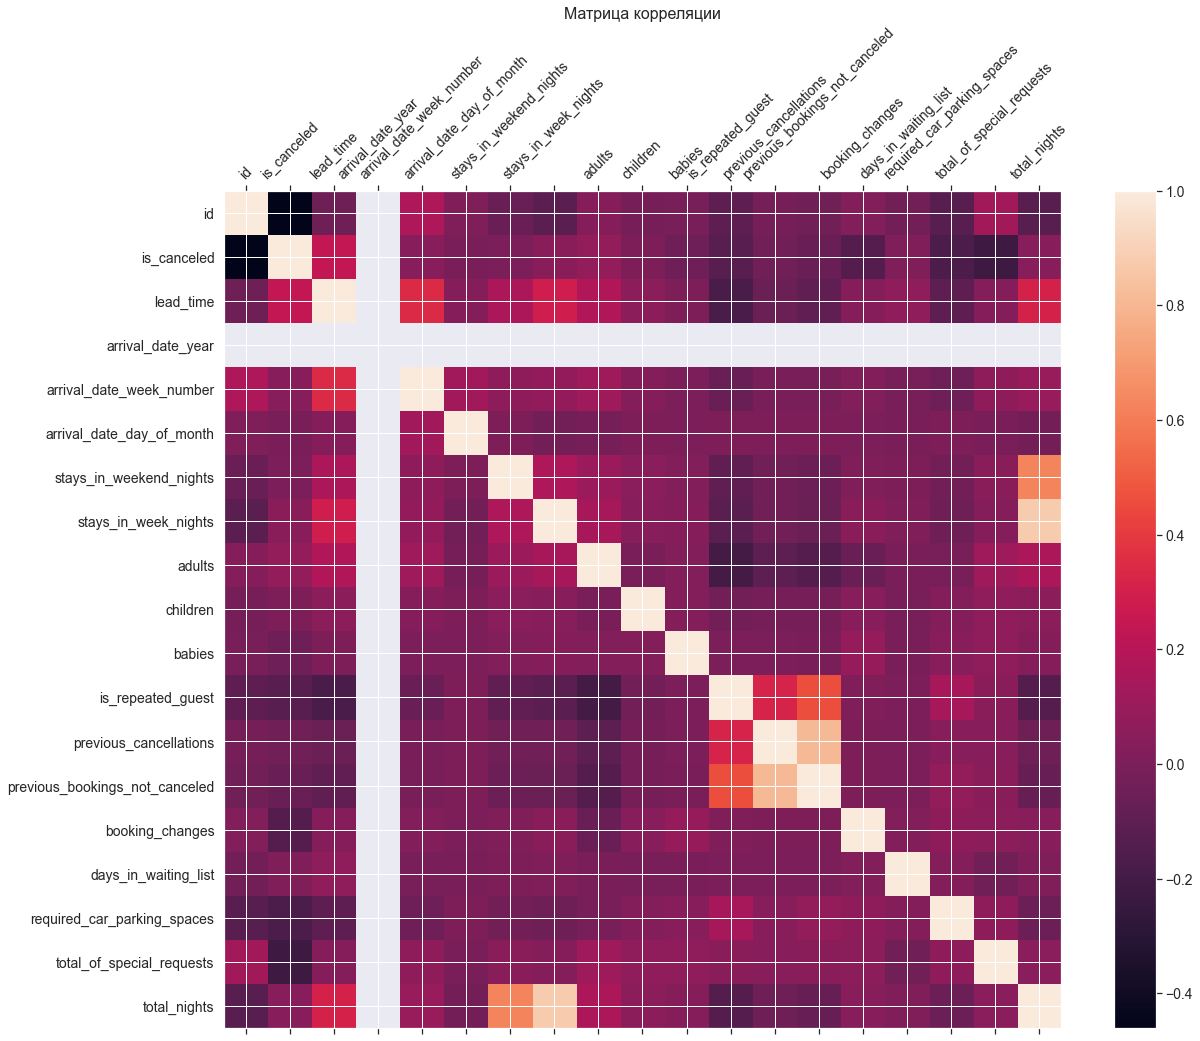

In [10]:
f = plt.figure(figsize=(19, 15))
plt.matshow(test.corr(), fignum=f.number)
plt.xticks(range(test.select_dtypes(['number']).shape[1]), test.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(test.select_dtypes(['number']).shape[1]),test.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Матрица корреляции', fontsize=16);

**Conclusion:**

Judging by the color scheme of the correlation matrices, at this stage it is difficult to find any linear relationships. Perhaps the connections are non-linear and not so obvious.

##### Review of data on the correlation matrix (point visualization of quantitative features)

In [11]:
matrix_1 = train[[
    'is_canceled',
    'arrival_date_week_number',
    'arrival_date_month',
    'adults',
    'arrival_date_year',
    'babies',
    'booking_changes'
]]

matrix_2 = train[[
    'is_canceled',
    'children',
    'country',
    'customer_type',
    'days_in_waiting_list',
    'distribution_channel',
    'is_repeated_guest',
    'lead_time'
]]

matrix_3 = train[[
    'is_canceled',
    'meal',                         
    'previous_bookings_not_canceled',
    'previous_cancellations', 
    'required_car_parking_spaces',
    'reserved_room_type',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'total_nights',
    'total_of_special_requests'
]]

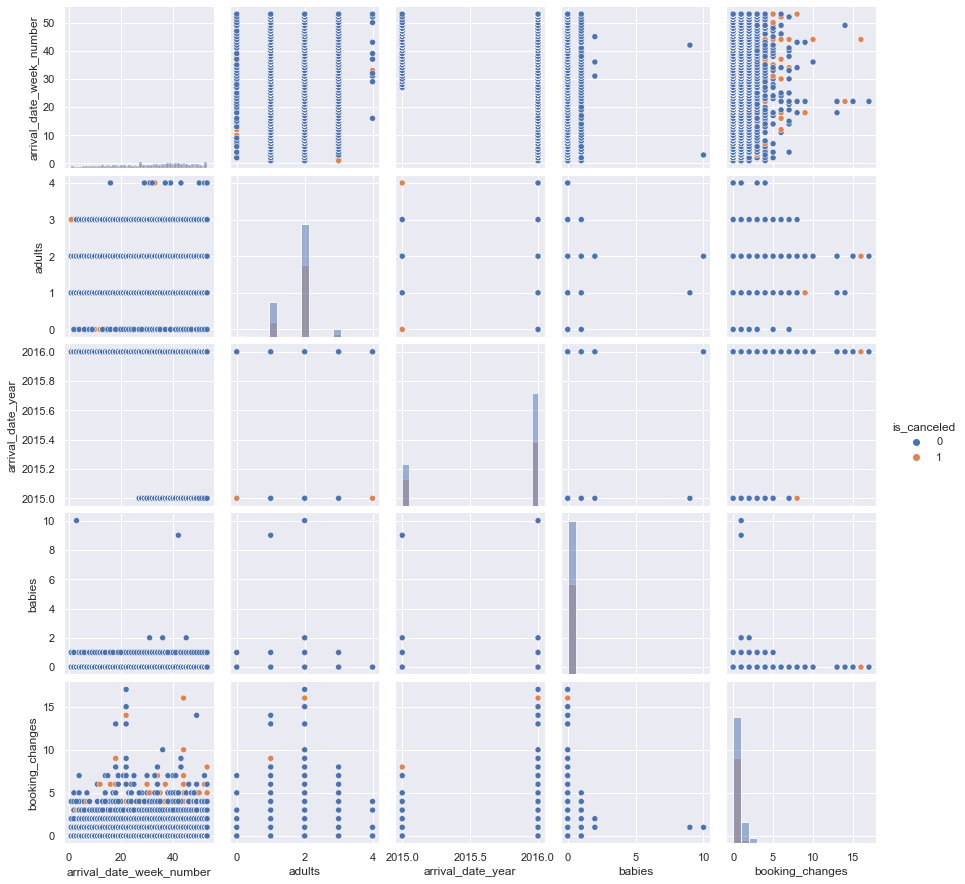

In [12]:
sns.pairplot(matrix_1, hue='is_canceled', diag_kind="hist");

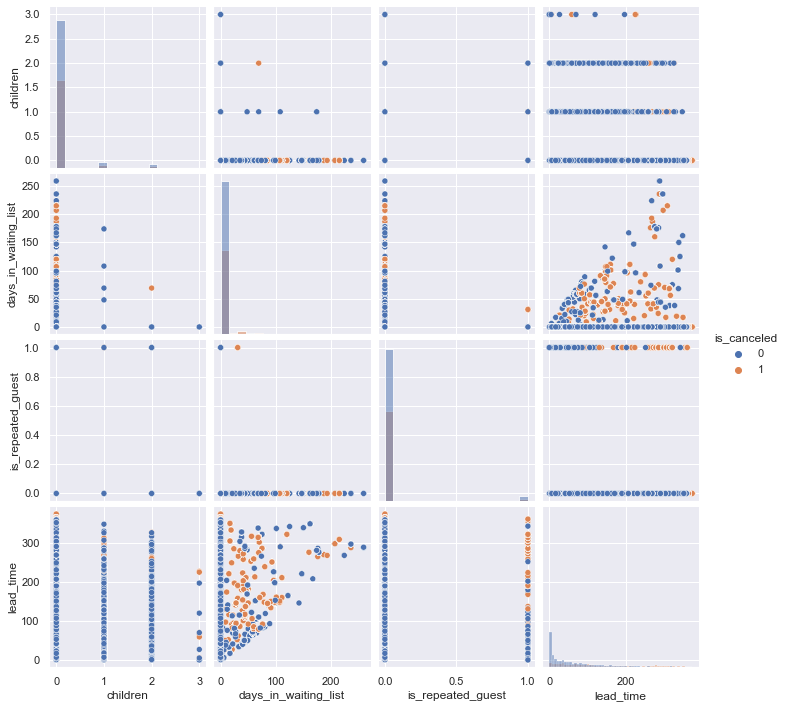

In [13]:
sns.pairplot(matrix_2, hue='is_canceled', diag_kind="hist");

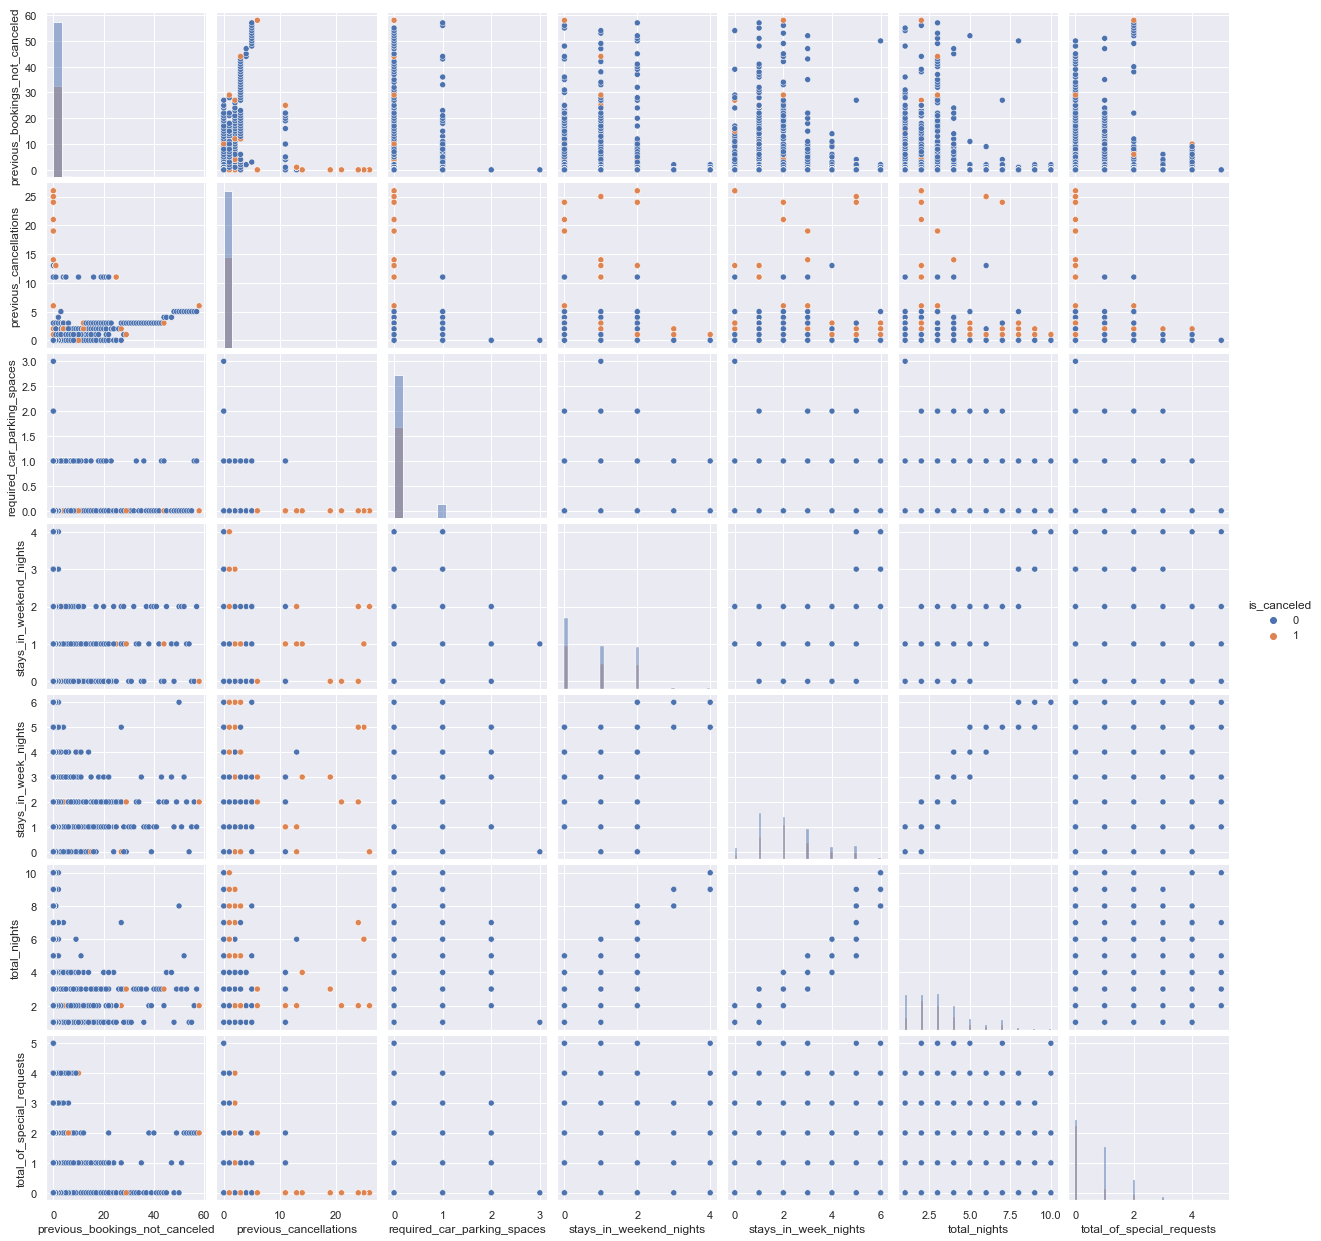

In [14]:
sns.pairplot(matrix_3, hue='is_canceled', diag_kind="hist");

Some dependencies can be seen on the correlation matrices.
- In the `previous_cancellations` column, there is a noticeable difference between the number of canceled and non-cancelled reservations. With an increase in the number of canceled applications in previous times, the chance of canceling the current application will increase.
- In the `previous_bookings_not_canceled` column, on the contrary, with an increase in confirmed bookings in previous times, the chance of canceling the current booking decreases.

Other than that, it's hard to see any correlations. The analysis of interrelations in categorical features is carried out below.

##### Visualization of shares of orders by categorical features

In [15]:
def featute_stat(var1, var2):
    num_canceled_count = train.pivot_table(index=var1, values='is_canceled', aggfunc='count')
    num_canceled_sum = train.pivot_table(index=var1, values='is_canceled', aggfunc='sum')
    canceled_frac = (num_canceled_sum / num_canceled_count).reset_index()
    canceled_frac.columns = ['type','canceled_fraction']
    canceled_frac = canceled_frac.sort_values(['canceled_fraction'])
    ax = plt.subplots(figsize=(12, 5))
    sns.barplot(x='type', y='canceled_fraction', data=canceled_frac, palette="Blues_d").set_title(var2, fontsize=14);

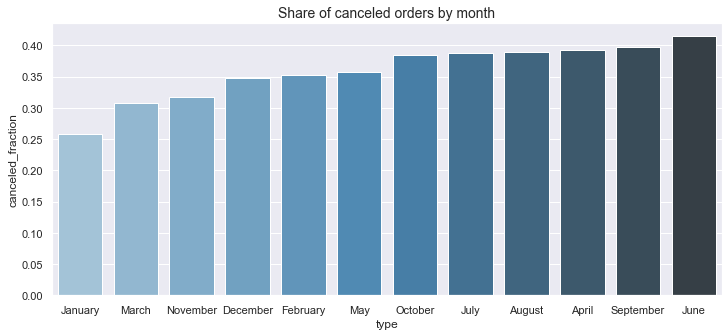

In [16]:
featute_stat('arrival_date_month','Share of canceled orders by month')

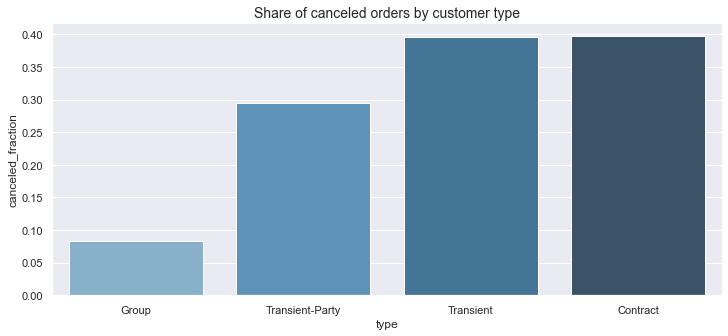

In [17]:
featute_stat('customer_type', 'Share of canceled orders by customer type')

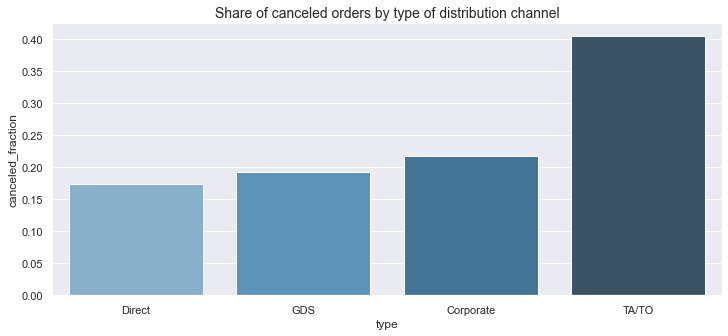

In [18]:
featute_stat('distribution_channel', 'Share of canceled orders by type of distribution channel')

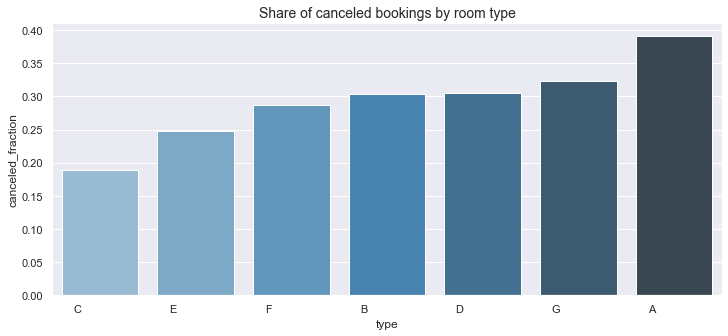

In [19]:
featute_stat('reserved_room_type', 'Share of canceled bookings by room type')

Next, let's start calculating the share of canceled orders among countries. Those countries are selected, the number of orders from which is at least 100. This is done on the basis of representativeness of the sample in order to prevent distortion of the result.

In [20]:
frequency_country = train['country'].value_counts()
name_country_frequency = frequency_country.loc[frequency_country > 100].reset_index()
name_country_frequency.head(5)

,index,country
0,PRT,28831
1,FRA,5974
2,GBR,5109
3,ESP,4900
4,DEU,3887


In [21]:
train_country_sorted = train.loc[train['country'].isin(name_country_frequency['index'])==True]

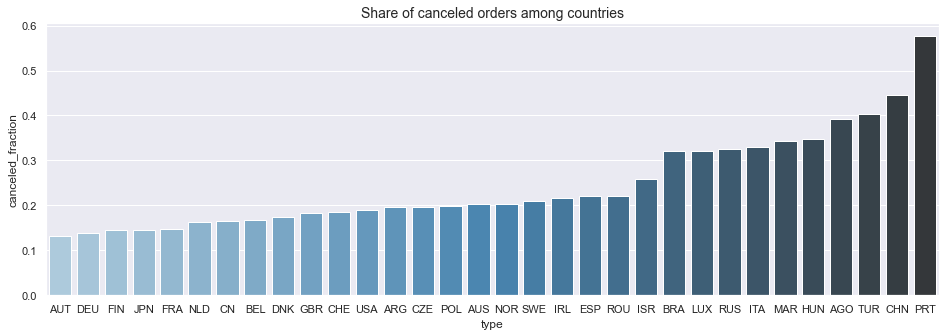

In [22]:
num_canceled_count = train_country_sorted.pivot_table(index='country', values='is_canceled', aggfunc='count')
num_canceled_sum = train_country_sorted.pivot_table(index='country', values='is_canceled', aggfunc='sum')
canceled_frac = (num_canceled_sum / num_canceled_count).reset_index()
canceled_frac.columns = ['type','canceled_fraction']
canceled_frac = canceled_frac.sort_values(['canceled_fraction'])
ax = plt.subplots(figsize=(16, 5))
sns.barplot(x='type', y='canceled_fraction', data=canceled_frac, palette="Blues_d").set_title('Share of canceled orders among countries', fontsize=14);

**Signs affecting the cancellation of the reservation:**
- `previous_cancellations` (the more previous canceled orders, the higher the cancellation rate)
- `previous_bookings_not_canceled` (the fewer confirmed bookings, the higher the chance of cancellation)
- `arrival_date_month` (in the warm season, the probability of booking cancellation is higher)
- `customer_type` (if the customer type is Transient or Contract, the probability of booking cancellation increases)
- `distribution_channel` (if the order was placed through the TA/TO distribution channel, the probability of cancellation is higher)
- `reserved_room_type` (among the category of room types, most often canceled reservations are among the most expensive rooms)
- `country` (customers from PRT countries cancel orders the most)

#### Data preprocessing

##### View unique values among categorical features

In [23]:
def uniq(tab):
    for column in tab:
        if tab[column].dtype=='object':
            print({tab[column].name : tab[column].sort_values().unique()})
            print('___________________________________________________________________________________________')

In [24]:
uniq(train)

{'arrival_date_month': array(['April', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September'],
      dtype=object)}
___________________________________________________________________________________________
{'meal': array(['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       '],
      dtype=object)}
___________________________________________________________________________________________
{'country': array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS',
       'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP',
       'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP',
       'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB',
       'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IR

In [25]:
uniq(test)

{'arrival_date_month': array(['April', 'August', 'February', 'January', 'July', 'June', 'March',
       'May'], dtype=object)}
___________________________________________________________________________________________
{'meal': array(['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       '],
      dtype=object)}
___________________________________________________________________________________________
{'country': array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF',
       'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BHS',
       'BIH', 'BLR', 'BRA', 'CAF', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR',
       'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DNK',
       'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI',
       'FRA', 'FRO', 'GAB', 'GBR', 'GHA', 'GIB', 'GNB', 'GRC', 'GTM',
       'HKG', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ',
       'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN',
       'KIR', 'KOR', '

In the `country` column, all non-matching classes in two samples are transferred to the `other` category. For the model to work correctly, the same number of columns in train and test is required. This must be done at this stage due to the peculiarities of data encoding in the future.

In [26]:
for i in test.country.unique():
    if i not in train.country.unique():
        test.country = test.country.replace(i, 'OTHER')

In [27]:
test.country.sort_values().unique()

array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ATA', 'AUS', 'AUT',
       'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BRA',
       'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI',
       'CUB', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY',
       'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GIB', 'GNB',
       'GRC', 'HKG', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN',
       'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ',
       'KEN', 'KOR', 'KWT', 'LBN', 'LBY', 'LIE', 'LKA', 'LTU', 'LUX',
       'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MLT', 'MNE', 'MOZ',
       'MUS', 'MYS', 'NGA', 'NLD', 'NOR', 'NZL', 'OTHER', 'PAK', 'PAN',
       'PER', 'PHL', 'POL', 'PRI', 'PRT', 'PRY', 'QAT', 'ROU', 'RUS',
       'SAU', 'SEN', 'SGP', 'SLV', 'SRB', 'STP', 'SUR', 'SVK', 'SVN',
       'SWE', 'SYC', 'SYR', 'THA', 'TJK', 'TUN', 'TUR', 'TWN', 'TZA',
       'UKR', 'URY', 'USA', 'UZB', 'VEN', 'VNM', 'ZAF', 'ZWE'],
      dtype=object)

All non-matching classes in the test set are marked with the category `other`✔️

#####  Removing implicit duplicates

There are implicit duplicates in the samples. In the `meal` column, the `SC` option is duplicated due to the presence gaps

In [28]:
train[['meal', 'reserved_room_type']] = train[['meal', 'reserved_room_type']].apply(lambda row: row.map(str.strip), axis=0) 
test[['meal', 'reserved_room_type']] = test[['meal', 'reserved_room_type']].apply(lambda row: row.map(str.strip), axis=0)

Implicit duplicates are removed ✔️

##### Feature coding

Copies of dataframes for future work with them

In [29]:
copy_train = train.copy()
copy_test = test.copy()
copy_test_1 = test.copy()
test_deposit = test.copy()

In [30]:
enc = OneHotEncoder(handle_unknown='ignore', drop = "first") # encoding of categorical features
train_enc = enc.fit_transform(train[['meal','country', 'distribution_channel', 'reserved_room_type','customer_type']]).toarray()
test_enc = enc.transform(test[['meal','country', 'distribution_channel', 'reserved_room_type','customer_type']]).toarray()

train_enc = pd.DataFrame(train_enc)
test_enc = pd.DataFrame(test_enc)

# removal of original features
train_drop = train.drop(['meal','country', 'distribution_channel', 'reserved_room_type','customer_type'], axis=1)
test_drop = test.drop(['meal','country', 'distribution_channel', 'reserved_room_type','customer_type'], axis=1)

# generating data with encoded features
train = train_drop.join(train_enc)
test = test_drop.join(test_enc)

C:\Users\Vadim\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [31]:
train.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,159,160,161,162,163,164,165,166,167,168
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
test.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,159,160,161,162,163,164,165,166,167,168
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Features are encoded ✔️

##### Extraction of the target feature

In [33]:
train_features = train.drop(['is_canceled', 'id', 'arrival_date_week_number', 'arrival_date_month'], 
                            axis=1) # training features of the training set
train_target = train['is_canceled'] # target feature

test_features = test.drop(['is_canceled', 'id', 'arrival_date_week_number', 'arrival_date_month'], 
                          axis=1) # training features of the test set
test_target = test['is_canceled'] # target feature

##### Feature scaling

In [34]:
numeric = ['adults',
           'arrival_date_year',
           'arrival_date_day_of_month',
           'babies', 'booking_changes',
           'children',
           'days_in_waiting_list',
           'lead_time',
           'stays_in_weekend_nights',
           'stays_in_week_nights',
           'total_nights'
] 

scaler = StandardScaler()
train_features.loc[:, numeric] = scaler.fit_transform(train_features.loc[:, numeric])
test_features.loc[:, numeric] = scaler.transform(test_features.loc[:, numeric])

In [35]:
train_features.head(5)

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,159,160,161,162,163,164,165,166,167,168
0,-0.929376,-1.599681,-1.697258,-0.966858,-0.903918,-1.741989,-0.22406,-0.073248,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.856555,-1.599681,-1.697258,-0.966858,-0.165901,0.340296,-0.22406,-0.073248,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.002196,-1.599681,-1.697258,-0.966858,-0.165901,0.340296,-0.22406,-0.073248,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.908570,-1.599681,-1.697258,-0.966858,-0.165901,0.340296,-0.22406,-0.073248,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.117948,-1.599681,-1.697258,-0.966858,0.572116,0.340296,-0.22406,-0.073248,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
test_features.head(5)

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,159,160,161,162,163,164,165,166,167,168
0,-0.232380,2.84993,-1.697258,0.204828,-1.641935,0.340296,-0.22406,-0.073248,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.357215,2.84993,-1.697258,1.376515,-0.165901,0.340296,-0.22406,-0.073248,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.357215,2.84993,-1.697258,1.376515,-0.165901,0.340296,-0.22406,-0.073248,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.263588,2.84993,-1.697258,1.376515,-0.165901,-1.741989,-0.22406,-0.073248,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.787107,2.84993,-1.697258,1.376515,2.048151,0.340296,-0.22406,-0.073248,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Features are scaled ✔️

### Step 3. Formulation of ML tasks based on business tasks

It is necessary to develop a model that will predict the cancellation of the reservation (target feature `is_canceled`). The higher the accuracy of the model, the higher the profit, respectively, the less the hotel will suffer losses. The model should pay off within a year.

** The effectiveness of the model must be compared with its absence, i.e. with a system without deposits. We will focus on the business metric - profit. We will compare the profit before and after the implementation of the model.**

In [37]:
COST_PER_NIGHT_A = 1000 # price per night for category A room
COST_PER_NIGHT_B = 800 # Price per night for category B room
COST_PER_NIGHT_C = 600 # Price per night for category C room
COST_PER_NIGHT_D = 550 # price per night for category D room
COST_PER_NIGHT_E = 500 # Price per night for category E room
COST_PER_NIGHT_F = 450 # price per night for category F room
COST_PER_NIGHT_G = 350 # price per night for category G room

ONE_OFF_SERVICE_A = 400 # one-time service for category A number
ONE_OFF_SERVICE_B = 350 # one-time service for category B number
ONE_OFF_SERVICE_C = 350 # one-time service for category C number
ONE_OFF_SERVICE_D = 150 # one-time service for category D number
ONE_OFF_SERVICE_E = 150 # one-time service for category E number
ONE_OFF_SERVICE_F = 150 # one-time service for category F number
ONE_OFF_SERVICE_G = 150 # one-time service for category G number

JANUARY_COEF = 1 # increase coefficient for the winter month
FEBRUARY_COEF = 1 # increase coefficient for the winter month
MARCH_COEF = 1.2 # increase coefficient for the spring month
APRIL_COEF = 1.2 # increase coefficient for the spring month
MAY_COEF = 1.2 # increase coefficient for the spring month
JUNE_COEF = 1.4 # increase coefficient for the summer month
JULY_COEF = 1.4 # increase coefficient for the summer month
AUGUST_COEF = 1.4 # increase coefficient for the summer month
SEPTEMBER_COEF = 1.2 # increase coefficient for the autumn month
OCTOBER_COEF = 1.2 # increase coefficient for the autumn month
NOVEMBER_COEF = 1.2 # increase coefficient for the autumn month
DECEMBER_COEF = 1 # increase coefficient for the winter month 


Next, the calculation will go to business metrics - profits. Profit is calculated as the difference between income and expenses.

Linking prices to categories through dictionaries:

In [38]:
room_type_dict = {          # linking price to room type
    "A": COST_PER_NIGHT_A,
    "B": COST_PER_NIGHT_B,
    "C": COST_PER_NIGHT_C,
    "D": COST_PER_NIGHT_D,
    "E": COST_PER_NIGHT_E,
    "F": COST_PER_NIGHT_F,
    "G": COST_PER_NIGHT_G
} 

In [39]:
season_coeff_price_dict = {     # linking the seasonal coefficient to the month
    'December': DECEMBER_COEF,
    'January': JANUARY_COEF,
    'February': FEBRUARY_COEF,
    'March': MARCH_COEF,
    'April': APRIL_COEF,
    'May': MAY_COEF,
    'June': JUNE_COEF,
    'July': JULY_COEF,
    'August': AUGUST_COEF,
    'September': SEPTEMBER_COEF,
    'October': OCTOBER_COEF,
    'November': NOVEMBER_COEF        
}

In [40]:
service_room_price_dict = {    # linking service cost per room type
    "A": ONE_OFF_SERVICE_A,
    "B": ONE_OFF_SERVICE_B,
    "C": ONE_OFF_SERVICE_C,
    "D": ONE_OFF_SERVICE_D,
    "E": ONE_OFF_SERVICE_E,
    "F": ONE_OFF_SERVICE_F,
    "G": ONE_OFF_SERVICE_G
} 

### Step 4. Developing the ML Model

#### Finding the best cross-validation model

##### Logistic Regression Model

In [41]:
%%time
best_model_lr = None
best_cv_score = 0
best_c = 0
for c in np.arange(1, 10, 1):
    model_lr = LogisticRegressionCV(random_state=12345, class_weight='balanced', solver="liblinear", cv=5, Cs=c)
    cv_score = np.mean(cross_val_score(model_lr, train_features, train_target, cv=5, scoring='f1'))
    if cv_score > best_cv_score:
        best_model_lr = model_lr 
        best_cv_score = cv_score
        best_c = c
print("F1 of best model:", best_cv_score)
print('Inverse of regularization strength:', best_c)

F1 of best model: 0.6833574495910355
Inverse of regularization strength: 6
Wall time: 8min 15s


- F1 of best model: 0.6833574495910355
- Inverse of regularization strength: 6
- Wall time: 8min 32s

##### Decision tree model

In [42]:
%%time
best_model_dt = None
best_cv_score = 0
best_depth = 0
for depth in range(1, 100):
    model_dt = DecisionTreeClassifier(max_depth=depth, random_state=12345) 
    cv_score = np.mean(cross_val_score(model_dt, train_features, train_target, cv=5, scoring='f1'))
    if cv_score > best_cv_score:
        best_model_dt = model_dt        
        best_depth = depth 
        best_cv_score = cv_score
print('F1 of best model:', best_cv_score)
print('Best depth:', best_depth)

F1 of best model: 0.6677867371030326
Best depth: 12
Wall time: 3min 32s


- F1 of best model: 0.6677867371030326
- Best depth: 12
- Wall time: 3min 26s

##### Random forest model

**Selection of the optimal number of trees**

In [43]:
%%time
best_model_rf = None
best_cv_score = 0
best_estimators = 0
for n in range(1, 100, 10):
    model_rf = RandomForestClassifier(n_estimators=n, max_depth= 100, random_state=12345, n_jobs=-1)
    cv_score = np.mean(cross_val_score(model_rf, train_features, train_target, cv=5, scoring='f1')) 
    if cv_score > best_cv_score:
        best_model_rf = model_rf
        best_cv_score = cv_score 
        best_estimators = n 
print("F1 of best model:", cv_score)
print("Number of trees:", best_estimators) 

F1 of best model: 0.62530746764728
Number of trees: 21
Wall time: 45.4 s


- F1 of best model: 0.62530746764728
- Number of trees: 21
- Wall time: 45.1 s

In [44]:
%%time
best_model_rf = None
best_cv_score = 0
best_estimators = 0
for n in range(20, 30, 1):
    model_rf = RandomForestClassifier(n_estimators=n, max_depth= 100, random_state=12345, n_jobs=-1)
    cv_score = np.mean(cross_val_score(model_rf, train_features, train_target, cv=5, scoring='f1')) 
    if cv_score > best_cv_score:
        best_model_rf = model_rf
        best_cv_score = cv_score 
        best_estimators = n 
print("F1 of best model:", cv_score)
print("Number of trees:", best_estimators) 

F1 of best model: 0.6314531811025471
Number of trees: 21
Wall time: 33.2 s


- F1 of best model: 0.62530746764728
- Number of trees: 21
- Wall time: 5min 26s

**Finding the best random forest depth**

In [45]:
%%time
best_model_rf = None
best_cv_score = 0
best_depth = 0
for depth in range(1, 100, 10):
    model_rf = RandomForestClassifier(n_estimators=21, max_depth= depth, random_state=12345, n_jobs=-1)
    cv_score = np.mean(cross_val_score(model_rf, train_features, train_target, cv=5, scoring='f1')) 
    if cv_score > best_cv_score:
        best_model_rf = model_rf
        best_cv_score = cv_score 
        best_depth = depth 
print("F1 of best model:", cv_score)
print("Best depth:", best_depth)

F1 of best model: 0.636642236305423
Best depth: 21
Wall time: 30.2 s


- F1 of best model: 0.636642236305423
- Best depth: 21
- Wall time: 28 s

In [46]:
%%time
best_model_rf = None
best_cv_score = 0
best_depth = 0
for depth in range(20, 30, 1):
    model_rf = RandomForestClassifier(n_estimators=21, max_depth= depth, random_state=12345, n_jobs=-1)
    cv_score = np.mean(cross_val_score(model_rf, train_features, train_target, cv=5, scoring='f1')) 
    if cv_score > best_cv_score:
        best_model_rf = model_rf
        best_cv_score = cv_score 
        best_depth = depth 
print("F1 of best model:", cv_score)
print("Best depth:", best_depth) 

F1 of best model: 0.6345204653653598
Best depth: 20
Wall time: 29.9 s


- F1 of best model: 0.6345204653653598
- Best depth: 20
- Wall time: 27.9 s

##### Support vector machines model

In [47]:
%%time
model_cvm = svm.SVC()
cv_score = np.mean(cross_val_score(model_cvm, train_features, train_target, cv=5, scoring='f1'))
print("F1 of best model:", cv_score)

F1 of best model: 0.6491511967362931
Wall time: 17min 16s


- F1 of best model: 0.6491511967362931
- Wall time: 16min 1s

Metric|Logistic Regression|Decision tree|Random forest model|Support vector machines 
--|:--:|:--:|:--:|:--:
f1|0.68|0.66|0.63|0.64

**Conclusion:** 4 models were considered during the study:
- logistic regression model
- decision tree model
- random forest model
- support vector model

The result of the model was evaluated by the cross-validation method. The best model on the training set was the logistic regression model with F1=0.68.

#### Training the best model (for each algorithm) on the entire training set and assessing the quality on the test set

Since the cross-validation method does not allow training the model on the entire volume of the training sample, the real quality metrics of such a model may differ from the metrics obtained on cross-validation. Therefore, the next step is to retrain the best model on the entire training set.

##### Decision tree model

In [48]:
%%time
best_model_dt = DecisionTreeClassifier(max_depth=12, random_state=12345).fit(train_features, train_target)
pred_test_target_dt = best_model_dt.predict(test_features)
f1 = f1_score(test_target, pred_test_target_dt)
precision = precision_score(test_target, pred_test_target_dt)
recall = recall_score(test_target, pred_test_target_dt)
MCC = matthews_corrcoef(test_target, pred_test_target_dt)
print('F1:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Matthews correlation coefficient:', MCC)

F1: 0.6403520963632151
Precision: 0.7684011563264398
Recall: 0.5488841235803351
Matthews correlation coefficient: 0.48308388365450516
Wall time: 509 ms


- F1: 0.6403520963632151
- Precision: 0.7684011563264398
- Recall: 0.5488841235803351
- Matthews correlation coefficient: 0.48308388365450516
- Wall time: 514 ms

##### Logistic Regression Model

In [49]:
%%time
best_model_lr = LogisticRegressionCV(random_state=12345, class_weight='balanced', solver="liblinear", cv=5, Cs=6).fit(train_features, train_target)
pred_test_target_lr = best_model_lr.predict(test_features)
f1 = f1_score(test_target, pred_test_target_lr)
precision = precision_score(test_target, pred_test_target_lr)
recall = recall_score(test_target, pred_test_target_lr)
MCC = matthews_corrcoef(test_target, pred_test_target_lr)
print("F1:", f1)
print('Precision:', precision)
print('Recall:', recall)
print('Matthews correlation coefficient:', MCC)

F1: 0.6870952667067227
Precision: 0.592618183912017
Recall: 0.817409260582956
Matthews correlation coefficient: 0.45001879028670155
Wall time: 19.2 s


- F1: 0.6870952667067227
- Precision: 0.592618183912017
- Recall: 0.817409260582956
- Matthews correlation coefficient: 0.45001879028670155
- Wall time: 15.4 s

##### Random forest model

In [50]:
%%time
model_rf = RandomForestClassifier(n_estimators=21, max_depth= 21, random_state=12345, n_jobs=-1).fit(train_features, train_target)
pred_test_target_rf = model_rf.predict(test_features)
f1 = f1_score(test_target, pred_test_target_rf)
precision = precision_score(test_target, pred_test_target_rf)
recall = recall_score(test_target, pred_test_target_rf)
MCC = matthews_corrcoef(test_target, pred_test_target_rf)
print('F1:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Matthews correlation coefficient:', MCC)

F1: 0.6352975524305386
Precision: 0.8201005025125628
Recall: 0.5184655706456993
Matthews correlation coefficient: 0.5052742759229429
Wall time: 378 ms


- F1: 0.6352975524305386
- Precision: 0.592618183912017
- Recall: 0.817409260582956
- Matthews correlation coefficient: 0.45001879028670155
- Wall time: 378 ms

##### Support vector machines model

In [51]:
%%time
model_cvm = svm.SVC(probability=True).fit(train_features, train_target)
pred_test_target_cvm = model_cvm.predict(test_features)
f1 = f1_score(test_target, pred_test_target_cvm)
precision = precision_score(test_target, pred_test_target_cvm)
recall = recall_score(test_target, pred_test_target_cvm)
MCC = matthews_corrcoef(test_target, pred_test_target_cvm)
print('F1:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Matthews correlation coefficient:', MCC)

F1: 0.6361013434316113
Precision: 0.7355854446877281
Recall: 0.5603208641092844
Matthews correlation coefficient: 0.46169475994650855
Wall time: 37min 1s


- F1: 0.6361013434316113
- Precision: 0.7355854446877281
- Recall: 0.5603208641092844
- Matthews correlation coefficient: 0.46169475994650855
- Wall time: 35min 37s

Metric|Logistic Regression|Decision tree|Random forest model|Support vector machines 
--|:--:|:--:|:--:|:--:
f1|0.68|0.64|0.63|0.63
MCC|0.45|0.48|0.45|0.46
Precision|0.59|0.76|0.59|0.73
Recall|0.81|0.54|0.81|0.56

Of all the metrics, one should pay attention to the Matthews correlation coefficient (MCC). This coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure that can be used even if the classes are of very different sizes. Therefore, a conclusion can be drawn best model is Decision Tree. **MCC** Decision Tree Model **0.48**

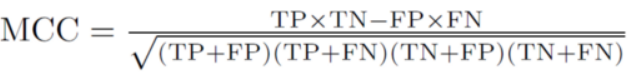

MCC can take values from -1 to +1. A model with a +1 rating is ideal. A model with a score of -1 is very weak. Unlike the other metrics discussed above, the Matthews correlation coefficient takes into account the values from all cells of the contingency matrix and thus is the most complete characteristic of the model.

**Precision	**: **0.76**. Precision is the ratio of the number of samples correctly classified as Positive to the total number of samples labeled Positive (recognized correctly and incorrectly). Precision measures the accuracy of the model when defining the Positive class.

**Recall** **0.54**. Recall is the ratio of the number of Positive samples correctly classified as Positive to the total number of Positive samples. Recall measures the ability of a model to detect samples that belong to the Positive class. The higher the recall, the more Positive samples were found.

**F1** joint score for precision and recall: **0.64**. It takes values ​​in the range from 0 to +1, where +1 is the estimate of the ideal model. F1 allows you to get a more balanced model performance than the metrics discussed above. However, since the F-measure does not take into account true negative predictions, this metric can also give a biased estimate. 

**Next, we derive the confusion matrix.**

The confusion matrix is a table with two rows and two columns, consisting of false positives, false negatives, true positives, and true negatives. This method also allows you to evaluate the quality of the model.

In [52]:
confusion_matrix = pd.DataFrame(confusion_matrix(test_target, pred_test_target_dt, labels=[0, 1]))
confusion_matrix.rename(columns = {0 : 'Positive', 1 : 'Negative'}, inplace = True)
confusion_matrix.index = ['Positive', 'Negative']

In [53]:
confusion_matrix 

,Positive,Negative
Positive,17738,2083
Negative,5680,6911


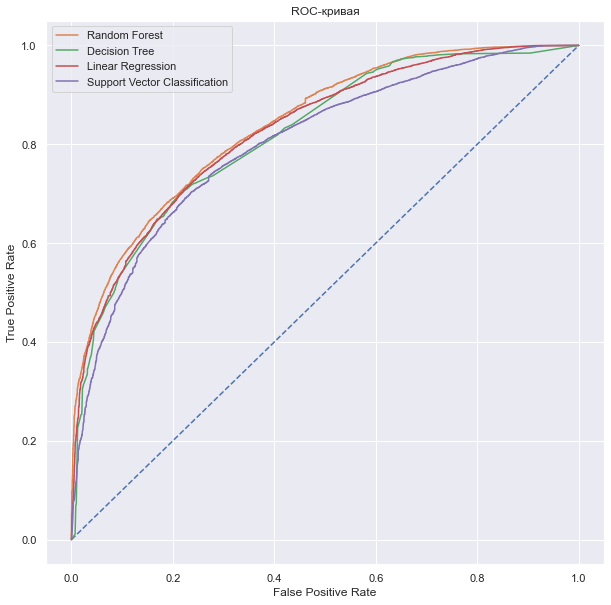

AUC-ROC Random Forest: 0.8397194322111177
AUC-ROC Decision Tree: 0.8191053315306374
AUC-ROC Linear Regression: 0.8276870000642835
AUC-ROC Support Vector Classification: 0.8025590571633915


In [54]:
plt.figure(figsize=(10, 10))
probabilities_test_rf = model_rf.predict_proba(test_features)
predictions_test_one_rf = probabilities_test_rf[:, 1]
probabilities_test_dt = best_model_dt.predict_proba(test_features)
predictions_test_one_dt = probabilities_test_dt[:, 1]
probabilities_test_lr = best_model_lr.predict_proba(test_features)
predictions_test_one_lr = probabilities_test_lr[:, 1]
probabilities_test_cvm = model_cvm.predict_proba(test_features)
predictions_test_one_cvm = probabilities_test_cvm[:, 1]

fpr_rf, tpr_rf, thresholds = roc_curve(test_target, predictions_test_one_rf)
fpr_dt, tpr_dt, thresholds_ = roc_curve(test_target, predictions_test_one_dt)
fpr_lr, tpr_lr, thresholds_ = roc_curve(test_target, predictions_test_one_lr)
fpr_cvm, tpr_cvm, thresholds_ = roc_curve(test_target, predictions_test_one_cvm)

auc_roc_rf = roc_auc_score(test_target , predictions_test_one_rf)
auc_roc_dt = roc_auc_score(test_target , predictions_test_one_dt)
auc_roc_lr = roc_auc_score(test_target , predictions_test_one_lr)
auc_roc_cvm = roc_auc_score(test_target , predictions_test_one_cvm)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_dt, tpr_dt, label='Decision Tree')
plt.plot(fpr_lr, tpr_lr, label='Linear Regression')
plt.plot(fpr_cvm, tpr_cvm, label='Support Vector Classification')
plt.legend()

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()
print('AUC-ROC Random Forest:', auc_roc_rf)
print('AUC-ROC Decision Tree:', auc_roc_dt)
print('AUC-ROC Linear Regression:', auc_roc_lr)
print('AUC-ROC Support Vector Classification:', auc_roc_cvm)

AUC-ROC is a graphical characteristic of the quality of a binary classifier, the dependence of the proportion of true positive classifications on the proportion of false positive classifications when varying the probability threshold of the classifier.

#### Business metrics for the test set

In [55]:
# replacing the old column with real data (is_canceled) with the one predicted by the model
pred_test_target_dt = pd.Series(pred_test_target_dt)
copy_test_1['is_canceled'] = pred_test_target_dt 

In [56]:
def profit_(df1, df2):
    # Profit calculation before the implementation of the cancellation prediction system:
    
    # new columns:
    # season_coeff_price - seasonal room rate increase,
    # room_type_price - price depending on room type,
    # service_room_expenses - room service expenses           
    df1['season_coeff_price'] = df1['arrival_date_month'].map(season_coeff_price_dict)
    df1['room_type_price'] = df1['reserved_room_type'].map(room_type_dict)
    df1['service_room_expenses'] = df1['reserved_room_type'].map(service_room_price_dict)
    
    # room_type_price_cor - room rates subject to seasonal increase
    df1['room_type_price_cor'] = df1['room_type_price'] * df1['season_coeff_price']
    # replacement with zero total_nights if the client canceled the reservation
    df1.loc[df1['is_canceled']== 1 , 'total_nights'] = 0  
    # room_type_revenue - revenue from renting a room for the time spent by the client in the hotel
    df1['room_type_revenue'] = df1['room_type_price_cor'] * df1['total_nights']
    # service_days - number of cleaning days
    df1['service_days'] = np.ceil(df1['total_nights']/2)
    # room service costs for the time spent by the client in the hotel
    df1['service_room_expenses'] = df1['service_room_expenses'] * df1['service_days']
    
    revenue1 = df1['room_type_revenue'].sum() - df1['service_room_expenses'].sum()
    
    print('+-----------------------------------------------------------------------------------------+')
    print('No deposit option. Calculation of business metrics on real data')
    print('+-----------------------------------------------------------------------------------------+')
    print('Annual income:',df1['room_type_revenue'].sum())
    print('Annual expenses:', df1['service_room_expenses'].sum())
    print('Annual profit:' , revenue1)
    
    
    # Calculation of profit after the introduction of a cancellation prediction system:
    
    # new columns:
    # season_coeff_price - seasonal room rate increase,
    # room_type_price - price depending on room type,
    # service_room_expenses - room service expenses        
    df2['season_coeff_price'] = df2['arrival_date_month'].map(season_coeff_price_dict)
    df2['room_type_price'] = df2['reserved_room_type'].map(room_type_dict)
    df2['service_room_expenses'] = df2['reserved_room_type'].map(service_room_price_dict)
    
    # room_type_price_cor - room rates subject to seasonal increase
    df2['room_type_price_cor'] = df2['room_type_price'] * df2['season_coeff_price']
    # accounting for a deposit of 80% of the cost of the room if the client cancels the reservation
    df2.loc[df2['is_canceled']== 1 , 'room_type_price_cor'] = df2['room_type_price_cor'] * 0.8  
    # room_type_revenue - revenue from renting a room for the time spent by the client in the hotel
    df2['room_type_revenue'] = df2['room_type_price_cor'] * df2['total_nights']
    # service_days - number of cleaning days
    df2['service_days'] = np.ceil(df2['total_nights']/2)
    # room service costs for the time spent by the client in the hotel
    df2['service_room_expenses'] = df2['service_room_expenses'] * df2['service_days']
    # the client covers 80% of the cost of a one-time cleaning with a deposit
    df2.loc[df2['is_canceled']== 1 , 'service_room_expenses'] = df2['service_room_expenses'] * 0.2
    
    revenue2 = df2['room_type_revenue'].sum() - df2['service_room_expenses'].sum()
    
    print('+-----------------------------------------------------------------------------------------+')
    print('Deposit option. Calculation of business metrics on predicted data')
    print('+-----------------------------------------------------------------------------------------+')
    print('Annual income:',df2['room_type_revenue'].sum())
    print('Annual expenses:', df2['service_room_expenses'].sum())
    print('Annual profit:' , revenue2)
    
    print('+-----------------------------------------------------------------------------------------+')
    print('Key business metrics')
    print('+-----------------------------------------------------------------------------------------+')
    print('The difference between profit before the implementation of the system and after the implementation:', revenue2 - revenue1)
    print('Percentage of profit growth after the implementation of the system:', '{:.1%}'.format((revenue2 - revenue1) / revenue1))
    print('+-----------------------------------------------------------------------------------------+')
    

In [57]:
profit_(copy_test, copy_test_1)

+-----------------------------------------------------------------------------------------+
No deposit option. Calculation of business metrics on real data
+-----------------------------------------------------------------------------------------+
Annual income: 65288980.0
Annual expenses: 11946650.0
Annual profit: 53342330.0
+-----------------------------------------------------------------------------------------+
Deposit option. Calculation of business metrics on predicted data
+-----------------------------------------------------------------------------------------+
Annual income: 103585936.0
Annual expenses: 15458470.0
Annual profit: 88127466.0
+-----------------------------------------------------------------------------------------+
Key business metrics
+-----------------------------------------------------------------------------------------+
The difference between profit before the implementation of the system and after the implementation: 34785136.0
Percentage of profit grow

### Step 5. Portrait of an "unreliable" client

**Based on exploratory data analysis, the following features can be identified that create the highest likelihood of cancellation by a client:**
- `previous_cancellations` (the more previous canceled orders, the higher the cancellation rate)
- `previous_bookings_not_canceled` (the fewer confirmed bookings, the higher the chance of cancellation)
- `arrival_date_month` (in the warm season, the probability of booking cancellation is higher)
- `customer_type` (if the customer type is Transient or Contract, the probability of booking cancellation increases)
- `distribution_channel` (if the order was placed through the TA/TO distribution channel, the probability of cancellation is higher)
- `reserved_room_type` (among the category of room types, most often canceled reservations are among the most expensive rooms)
- `country` (customers from PRT countries cancel orders the most)

### Step 6. General conclusion

In the course of this study, a model was created to predict customer cancellations.

4 popular ML algorithms were considered. The best hyperparameters of all 4 models were selected using cross-validation. Decision Tree proved to be the best model. Then this model was trained on test data with subsequent evaluation by quality metrics.

Of all the machine learning metrics with which the model was evaluated, the most significant are *f1 measure*, *Matthews correlation coefficient (MCC)* and *area under the rock curve (AUC-ROC)*.
- F1-measure = 0.64
- MCC = 0.48
- AUC-ROC = 0.81

The key business metric was *profit*. The profit was calculated before the introduction of the deposit system, then after the introduction, and after that the difference between them was considered (the value by which the profit increased).

Annual profit before the introduction of deposits: *53342330*

Annual profit after implementation: *88127466*

Profit growth: *34785136*

Percentage of profit growth after the implementation of the system: *40.4%*

**The budget for the development of the model is 400,000, therefore, we can conclude that the model has paid for itself many times over.**